# Reverse Engineering what the raw CAN packets mean
Going to leverage data from forscan to see what they mean

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import struct
plt.rcParams['figure.figsize'] = [20,5]

In [2]:
fnameFORScan = "~/car/CANDumps/LiveData_2018-07-27_21.14.04.csv"
fnameSavvyCAN = "~/car/CANDumps/savvycan_drivingdump_20180727.csv"

In [3]:
def readFORScan(fname):
    ''' 
    read a forscan output file to a dataframe
    # format is:
    | time[ms] | DATA1 | DATA2 | ... | DATA3 |
    |  <time>  | <val> | <val> | ... | <val> |
    '''
    
    delimiters = [";",","]
    for delim in delimiters:
        try:
            data = pd.read_csv(fnameFORScan,delimiter=delim)
            break
        except:
            print("Delimiter is not {}".format(delim))

    #clean up column names
    newCols = {}
    for col in data.columns:
        loc = col.find("(")
        if loc > 0:
            newCols.update({col:col[:loc]})
    data = data.rename(index=bytes,columns=newCols)
    data = data[data.time>1000] # eliminate the first second of data, may have bad values
    data = data.reset_index(drop=True) # reset the inde
    for c in data.columns:
        if data[c][0] == "Off" or data[c][0] == "On":
            data[c][data[c] == "Off"] = 0
            data[c][data[c] == "On"] = 1

    data = data.astype(np.float32)
    data["time"] = data.apply(lambda row: row["time"]/1e3,axis=1)
    return data

def readSavvyCAN(fname):
    '''
    read the savvycan dump to a dataframe
    '''
    dtype = {'Time Stamp':np.float32, 'ID':bytes, 'Extended':bool, 'Dir':str, 'Bus':int, 'LEN':int,
                            'D1':bytes, 'D2':bytes, 'D3':bytes,'D4':bytes, 'D5':bytes, 'D6':bytes, 'D7':bytes, 'D8':bytes}
    data = pd.read_csv(fname,index_col=False,dtype=dtype)# savvycan adds extra comma at end of line
    
    def convertToBytes(x):
        return bytes.fromhex(x)
    for col in ["ID","D1","D2","D3","D4","D5","D6","D7","D8"]:
        data[col] = data.apply(lambda row: convertToBytes(row[col]),axis=1)
        
    minVal = data["Time Stamp"].min()/1e6
    
    data["Time Stamp"] = data.apply(lambda row: row["Time Stamp"]/1e6-minVal,axis=1)

    return data

In [4]:
def convertTo_int8(data):
    '''
    Convert bytes into signed 8bit integer values
    '''
    length = len(data)
    
    return struct.unpack(length*"b",data)

def convertTo_uint8(data):
    '''
    Convert bytes into un-signed 8bit integer values
    '''
    length = len(data)
    return struct.unpack(length*"B",data)

def convertTo_int16(data):
    '''
    Convert 2 bytes into signed 16bit integer values
    '''
    return struct.unpack("h",data)[0]

In [5]:
dff = readFORScan(fnameFORScan)
dfs = readSavvyCAN(fnameSavvyCAN)

/home/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0x730 return on 0x738: Electronic Power Steering module

0x731 return on 0x739: SSU 

0x760 return on 0x768: ABS module

0x7E0 return on 0x7E8: Power Control Module


# Steering Angle
ID: \x738    Data: \x05 \x62 \x33 \x02

Convert by: struct.unpack("h",byte6 + byte5)[0]/10-780

Units: Degrees

FORScan  min: -394.500 max: 73.700 mean: -77.822
SavvyCAN min: -394.500 max: 73.700 mean: -82.730


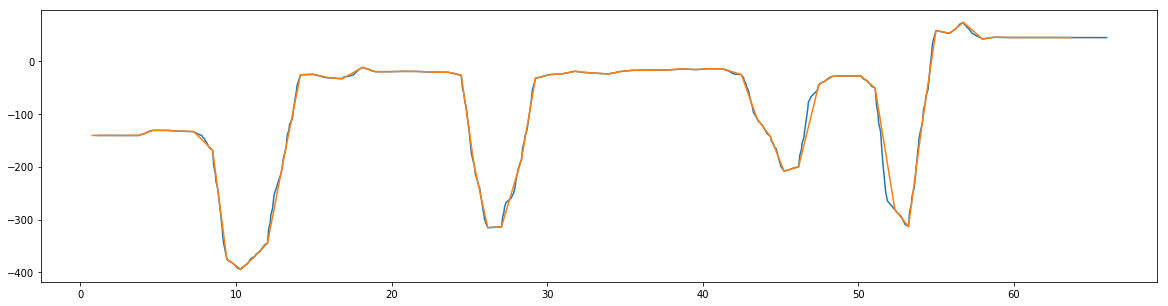

In [6]:
# filter by steering angle
angle = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x02")]
angle = angle.reset_index(drop=True)
a = angle.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)
a_converted = a/10-780

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(dff["STR_ANG"].min(),dff["STR_ANG"].max(),dff["STR_ANG"].mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(a_converted.min(),a_converted.max(),a_converted.mean()))

plt.plot(dff["time"],dff["STR_ANG"])
plt.plot(angle["Time Stamp"],a_converted)
plt.show()

# Steering Torque
ID: \x738    Data: \x04 \x62 \x33 \x0B

Convert by:(struct.unpack("B",byte5)[0]-127)/10

Units: N*m

FORScan  min: -3.200 max: 2.800 mean: -0.051
SavvyCAN min: -3.200 max: 2.800 mean: -0.034


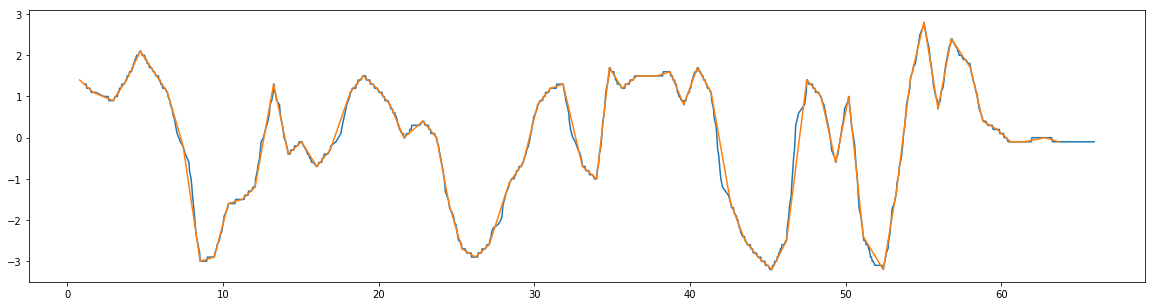

In [7]:
# filter by steering angle
torque = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x0b")]
torque = torque.reset_index(drop=True)
t = torque.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
t = (t-127)/10

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(dff["STR_TRQ_S_M"].min(),
                                                             dff["STR_TRQ_S_M"].max(),dff["STR_TRQ_S_M"].mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(t.min(),t.max(),t.mean()))

plt.plot(dff["time"],dff["STR_TRQ_S_M"])
plt.plot(torque["Time Stamp"],t)
plt.show()

# Steering Speed
ID: \x738    Data: \x04 \x62 \x33 \x01

Convert by: struct.unpack("B",byte5)[0]*4

Units: degrees/second


FORScan  min: 0.000 max: 276.000 mean: 42.232
SavvyCAN min: 0.000 max: 276.000 mean: 43.164


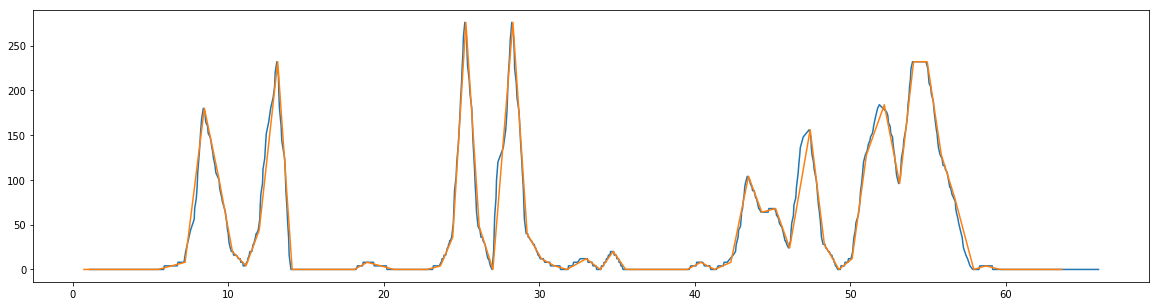

In [8]:
speed = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x01")]
speed = speed.reset_index(drop=True)

s = speed.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)

f = np.array(dff["STR_ROT_SPD"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(speed["Time Stamp"])
s_converted = s*4

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f)
plt.plot(s_time,s_converted)
plt.show()

# Brake Pressure
ID: \x768    Data: \x05 \x62 \x20 \x34

Convert by: struct.unpack("h",byte6 + byte5)[0]*33.3

Units: kPa


FORScan  min: 0.000 max: 12254.400 mean: 889.949
SavvyCAN min: 0.000 max: 12254.400 mean: 846.701


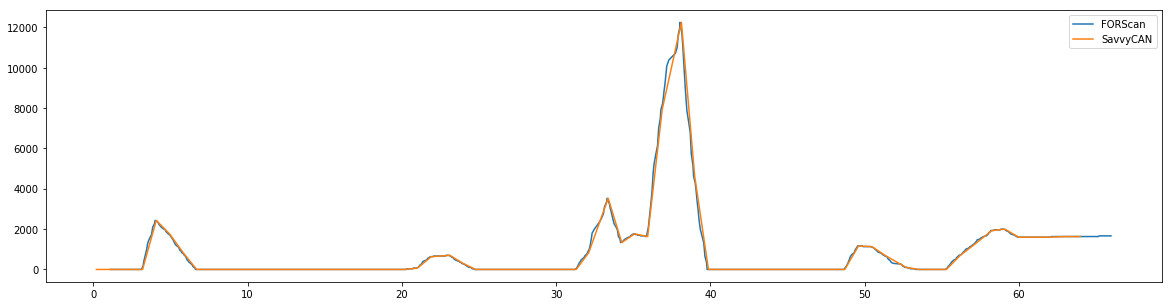

In [9]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x20")& (dfs["D4"]==b"\x34")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["BRK_F_P_C"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s*33.3

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Front Left wheel speed sensor
ID: \x768    Data: \x04 \x62 \x2b \x06

Convert by: struct.unpack("h",byte6 + byte5)[0]/255

Units: kph


FORScan  min: 0.000 max: 38.000 mean: 11.093
SavvyCAN min: 0.000 max: 38.149 mean: 11.208


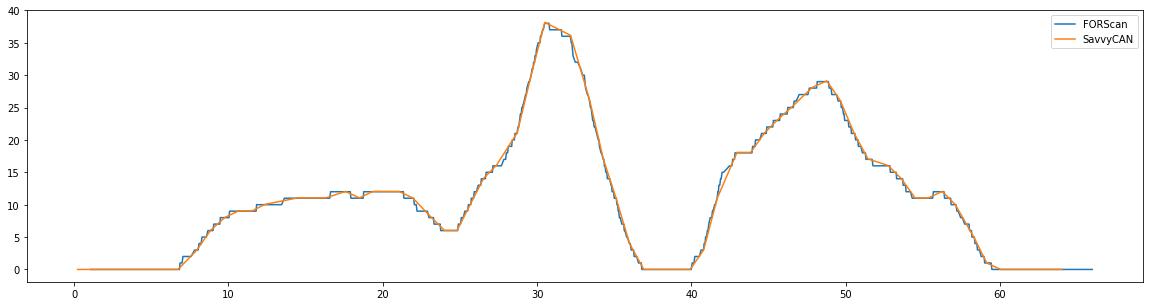

In [20]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x2b")& (dfs["D4"]==b"\x06")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["WSPD_SEN_LF"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/255

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Front Right wheel speed sensor
ID: \x768    Data: \x04 \x62 \x2b \x07

Convert by: struct.unpack("h",byte6 + byte5)[0]/255

Units: kph


FORScan  min: 0.000 max: 37.000 mean: 10.594
SavvyCAN min: 0.000 max: 37.145 mean: 10.689


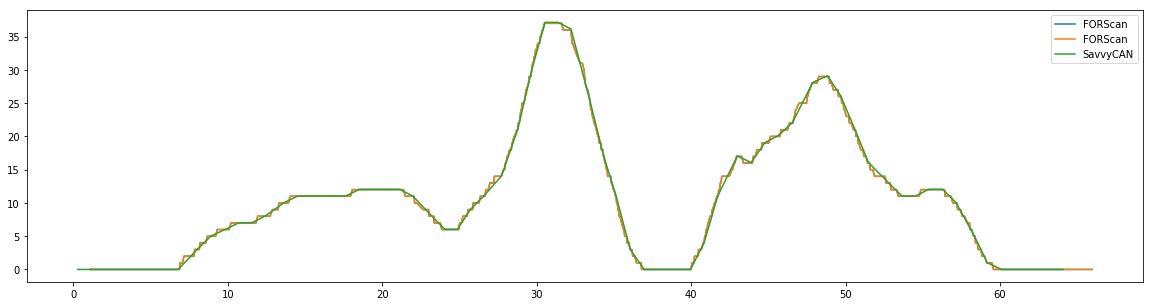

In [21]:

savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x2b")& (dfs["D4"]==b"\x07")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["WSPD_SEN_RF"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/255

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Rear Left wheel speed sensor
ID: \x768    Data: \x04 \x62 \x2b \x08

Convert by: struct.unpack("h",byte6 + byte5)[0]/255

Units: kph


FORScan  min: 0.000 max: 38.000 mean: 10.893
SavvyCAN min: 0.000 max: 38.149 mean: 10.984


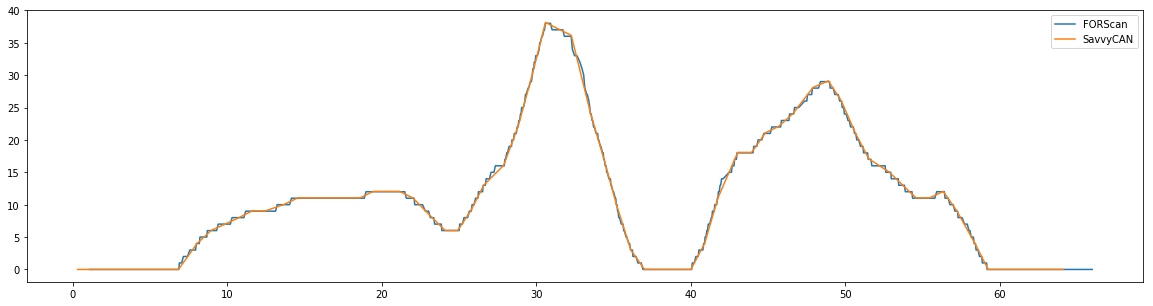

In [22]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x2b")& (dfs["D4"]==b"\x08")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["WSPD_SEN_LR"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/255

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Rear Right wheel speed sensor
ID: \x768    Data: \x04 \x62 \x2b \x09

Convert by: struct.unpack("h",byte6 + byte5)[0]/255

Units: kph


FORScan  min: 0.000 max: 38.000 mean: 10.472
SavvyCAN min: 0.000 max: 38.149 mean: 10.571
SavvyCAN min: 0.000 max: 38.149 mean: 10.571


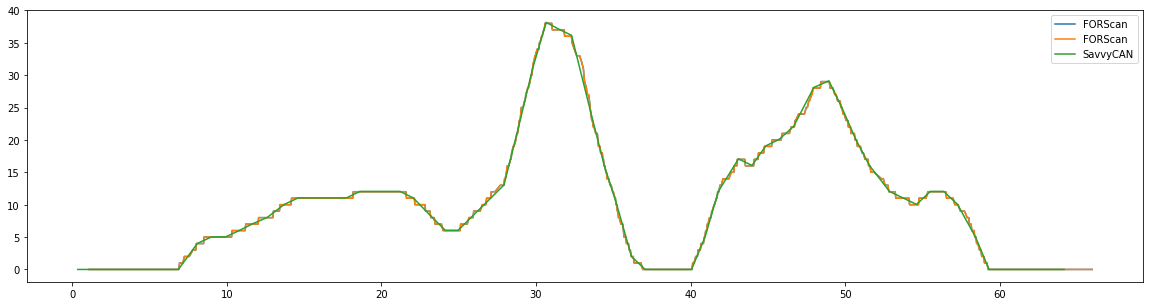

In [23]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x2b")& (dfs["D4"]==b"\x09")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["WSPD_SEN_RR"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/255

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Longitudinal Acceleration
ID: \x768    Data: \x05 \x62 \x2b \x11

Convert by: struct.unpack("h",byte6 + byte5)[0]/1000

Units: G


FORScan  min: -0.280 max: 0.360 mean: -0.012
SavvyCAN min: -0.277 max: 0.360 mean: -0.009
SavvyCAN min: -0.277 max: 0.360 mean: -0.009


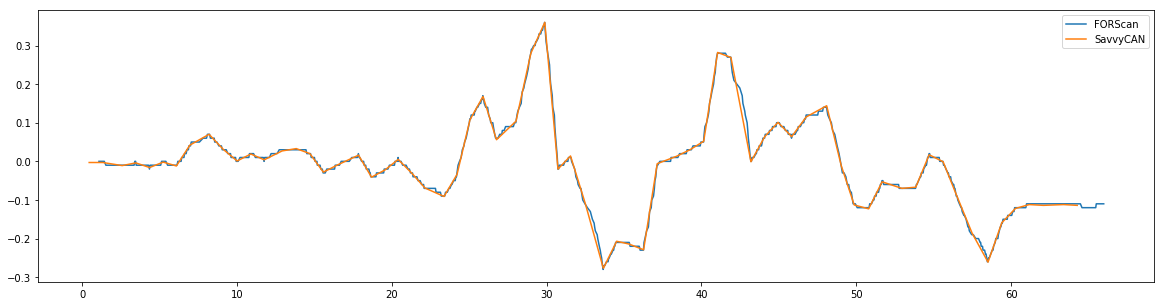

In [24]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x2b")& (dfs["D4"]==b"\x11")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["LON_ACCL_R"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/1000

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Lateral Acceleration
ID: \x768    Data: \x05 \x62 \x2b \x0c

Convert by: struct.unpack("h",byte6 + byte5)[0]/255

Units: G


FORScan  min: -0.290 max: 0.060 mean: -0.033
SavvyCAN min: -0.282 max: 0.059 mean: -0.032
SavvyCAN min: -0.282 max: 0.059 mean: -0.032


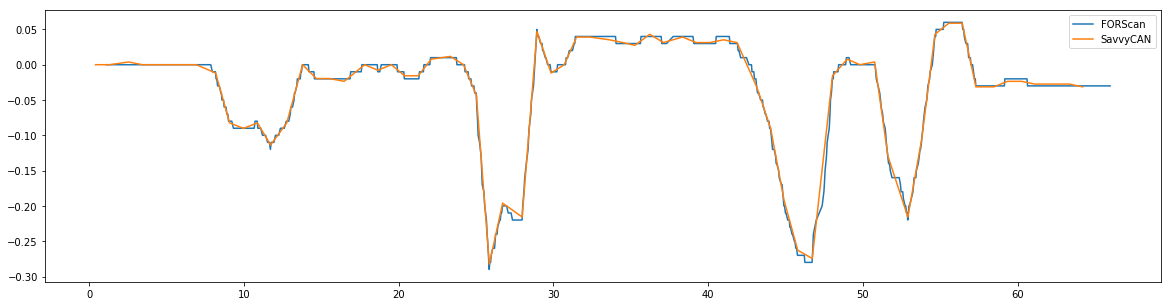

In [25]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x2b")& (dfs["D4"]==b"\x0c")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["LAT_ACCL_R"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/255

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Vehicle Speed
ID: \x768    Data: \x04\x62 \xf4 \x0d

Convert by: struct.unpack("h",byte6 + byte5)[0]/255

Units: kph


FORScan  min: 0.000 max: 38.000 mean: 10.719
SavvyCAN min: 0.000 max: 38.149 mean: 10.822


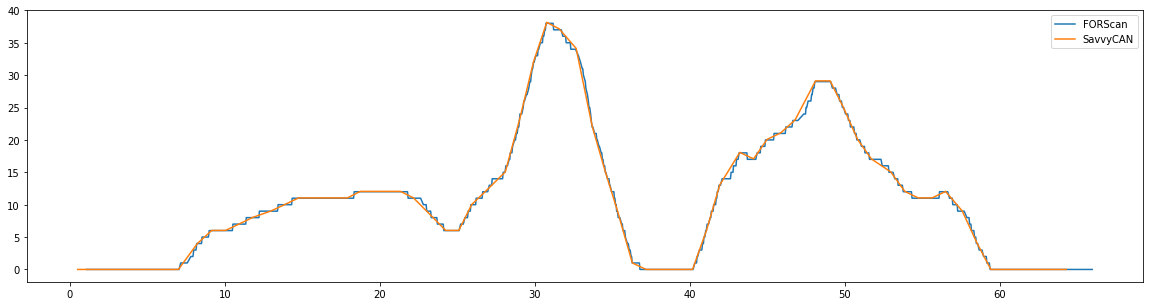

In [26]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\x68") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\xf4")& (dfs["D4"]==b"\x0d")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)

f = np.array(dff["VSS"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/255

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Accelerator position
ID: \x7E8    Data: \x04\x62 \x03 \x2b

Convert by: struct.unpack("B",byte5)[0]/2

Units: percent


FORScan  min: 0.000 max: 77.000 mean: 6.128
SavvyCAN min: 0.000 max: 77.000 mean: 6.080
SavvyCAN min: 0.000 max: 77.000 mean: 6.080


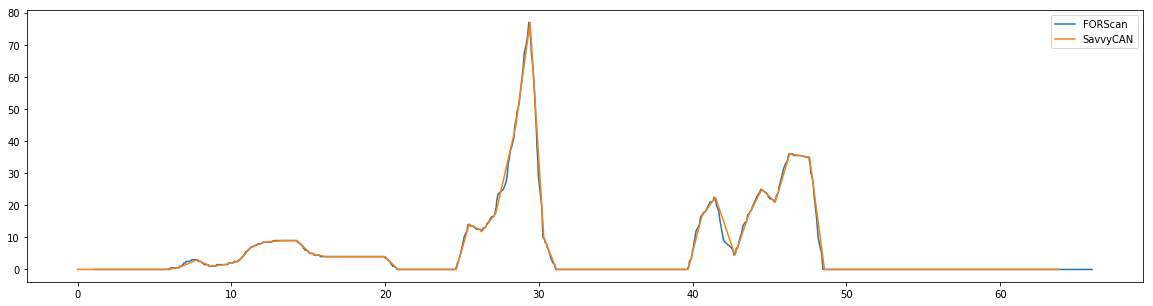

In [27]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\xE8") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x03")& (dfs["D4"]==b"\x2b")]
savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)

f = np.array(dff["APP"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/2

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Clutch applied
ID: \x7E8    Data: \x07\x62 \x1e \x04

Convert by: struct.unpack("B",byte7)[0]

Units: not sure....

Discrete values recorded are: 0x00, 0x20, 0x80, 0xC0

Looks like it might be a 2 stage measurement, like clutch is parially pushed in 


FORScan  min: 0.000 max: 1.000 mean: 0.535
SavvyCAN min: 0.000 max: 0.640 mean: 0.441
SavvyCAN min: 0.000 max: 0.640 mean: 0.441


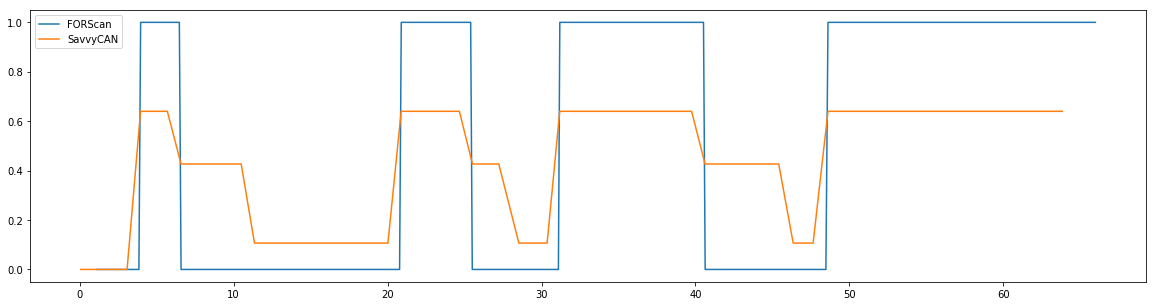

In [28]:
savvy = dfs[(dfs["ID"]==b"\x00\x00\x07\xE8") & (dfs["D1"]==b"\x07")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x1e")& (dfs["D4"]==b"\x04")]

savvy = savvy.reset_index(drop=True)

s = savvy.apply(lambda row: convertTo_uint8(row["D7"])[0],axis=1)

f = np.array(dff["CPP"])
f_time = np.array(dff["time"])
s = np.array(s)
s_time = np.array(savvy["Time Stamp"])
s_converted = s/300

print("FORScan  min: {:.3f} max: {:.3f} mean: {:.3f}".format(f.min(),f.max(),f.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))
print("SavvyCAN min: {:.3f} max: {:.3f} mean: {:.3f}".format(s_converted.min(),s_converted.max(),s_converted.mean()))

plt.plot(f_time,f,label="FORScan")
plt.plot(s_time,s_converted,label="SavvyCAN")
plt.legend()
plt.show()

# Turn Signal 
ID: \x739    Data: \x05 \x62 \xD9 \x80

Convert by:
  * None On: byte5 == b'\x10'
  * Left:    byte5 == b'\x11'
  * Right:   byte5 == b'\x12'

Units: Bool


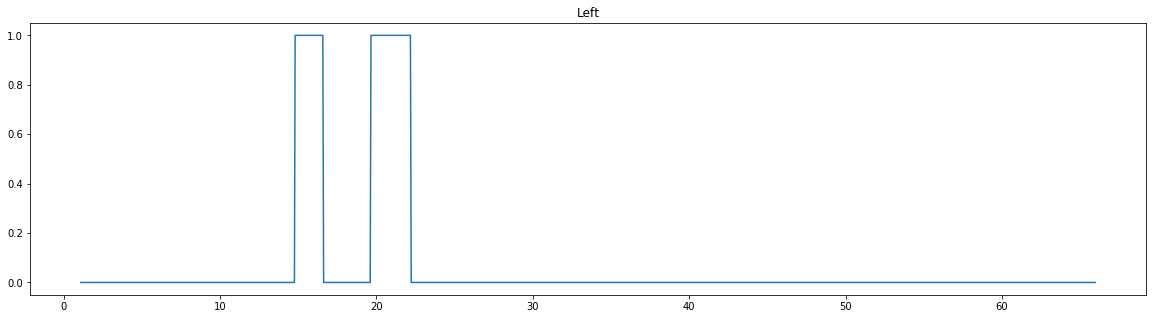

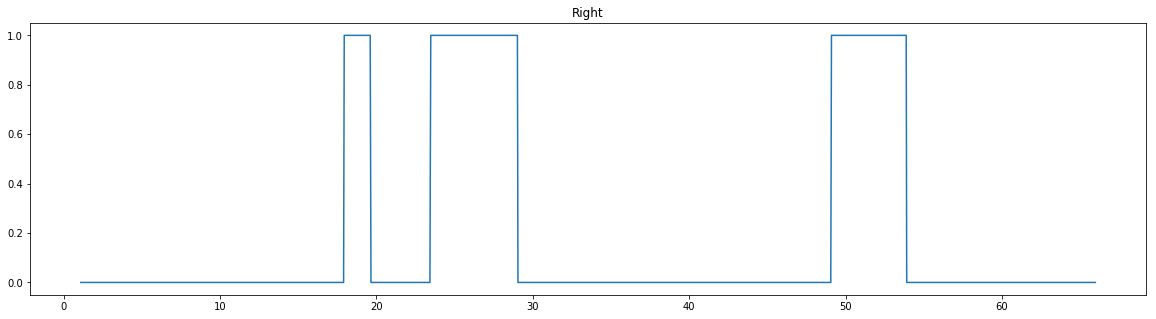

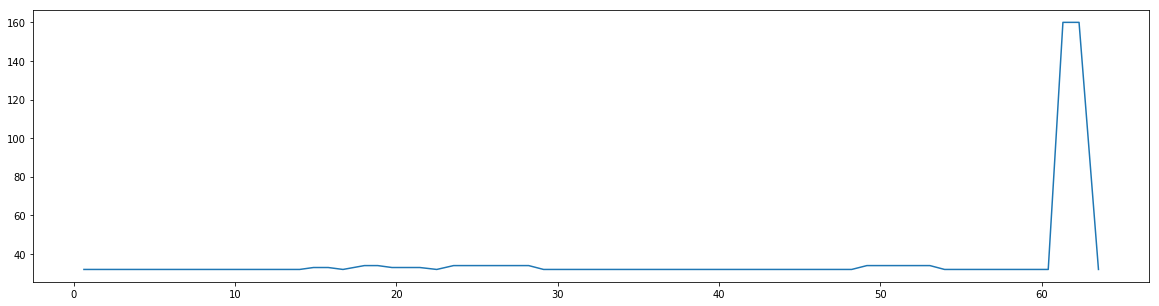

Unique values for signal: [b' ' b'!' b'"' b'\xa0']


In [19]:
signal = dfs[(dfs["ID"]==b"\x00\x00\x07\x39") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\xD9")& (dfs["D4"]==b"\x80")]
signal = signal.reset_index(drop=True)

plt.plot(dff["time"],dff["TURN_SW_L"])
plt.title("Left")
plt.show()
plt.plot(dff["time"],dff["TURN_SW_R"])
plt.title("Right")
plt.show()


s = signal.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
plt.plot(signal["Time Stamp"],s)
plt.show()
print("Unique values for signal: {}".format(signal["D5"].unique()))